In [76]:
import pandas as pd
import json
import duckdb
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import os
load_dotenv()
import matplotlib
import warnings
warnings.filterwarnings('ignore')

In [77]:
import os
from ollama import Client
from phoenix.otel import register

In [78]:
from openinference.semconv.trace import SpanAttributes
from opentelemetry.trace import Status, StatusCode
from openinference.instrumentation import TracerProvider

# Phoenix

In [79]:
PROJECT_NAME = "tracing-agent"

In [80]:
tracer_provider = register(
  project_name=PROJECT_NAME,
  endpoint="https://app.phoenix.arize.com/s/gangwaranshu3/v1/traces",
  api_key=os.getenv("PHOENIX_API_KEY"),
  auto_instrument=True
)

Overriding of current TracerProvider is not allowed


🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: tracing-agent
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: https://app.phoenix.arize.com/s/gangwaranshu3/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {'authorization': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [81]:
from opentelemetry.instrumentation.ollama import OllamaInstrumentor

In [82]:
OllamaInstrumentor().instrument(tracer_provider = tracer_provider)

Attempting to instrument while already instrumented


In [83]:
client = Client(
    host='https://ollama.com',
    headers={'Authorization': 'Bearer ' + os.environ.get('OLLAMA_API_KEY')}
)

In [84]:
model = 'qwen3-coder:480b-cloud'

In [85]:
tracer = tracer_provider.get_tracer(__name__)

In [86]:
tracer

In [87]:
# define the path to the transactional data
TRANSACTION_DATA_FILE_PATH = 'data/Store_Sales_Price_Elasticity_Promotions_Data.parquet'

In [46]:
# Prompt template for step 2 of tool 1
SQL_GENERATION_PROMPT = """ 
Generate an SQL query based on a prompt. Do not reply with anything besides the sql query.
The prompt is {prompt}

The available columns are: {columns}
Table name is: {table_name}
"""


In [12]:
def generate_sql_query(prompt: str, columns: list, table_name: str) -> str:
    """Generate an SQL query based oon a prompt"""
    formatted_prompt = SQL_GENERATION_PROMPT.format(
        prompt=prompt,
        columns=columns,
        table_name=table_name
    )
    response = client.chat(
        model=model,
        messages = [{"role": "user", "content": formatted_prompt}]
    )
    return response.message.content  

In [56]:
@tracer.tool()
def look_up_sales_data(prompt: str) ->str:
    """Implementation of sales lookup from parquet file using SQL"""
    try:
        # Define the table name
        table_name = "sales"

        # step 1: load the data
        df = pd.read_parquet(TRANSACTION_DATA_FILE_PATH)
        duckdb.sql(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * FROM df")

        # step 2: generate the sql query
        sql_query = generate_sql_query(prompt, df.columns, table_name)
        # clean the response to make sure it only includes the sql code
        sql_query = sql_query.strip()
        sql_query = sql_query.replace("```sql", "").replace("```", "")
        
        # step 3: execute the SQL query
        result = duckdb.sql(sql_query).df()

        return result.to_string()
    except Exception as e:
        return f"Error occurred: {str(e)}"

In [14]:
example_data = look_up_sales_data("Show me all the sales for store 1320 on November 1st, 2021")
print(example_data)

Transient error Internal Server Error encountered while exporting span batch, retrying in 1.06s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 2.36s.
Failed to export span batch code: 500, reason: 


    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo
0           1320    6173050               22875 2021-11-01         1          4.990000         0
1           1320    6174250               22875 2021-11-01         1          0.890000         0
2           1320    6176200               22975 2021-11-01         2         99.980003         0
3           1320    6176800               22800 2021-11-01         1         14.970000         0
4           1320    6177250               22975 2021-11-01         1          6.890000         0
5           1320    6177300               22800 2021-11-01         1          9.990000         0
6           1320    6177350               22800 2021-11-01         2         16.980000         0
7           1320    6177700               22875 2021-11-01         1          3.190000         0
8           1320    6178000               22875 2021-11-01         2          6.380000         0
9           1320    6178250   

### Tool 2: Data Analysis

The second tool can analyze the returned data and display conclusions to users.

<img src="images/tool2.png" width="300"/>

In [57]:
# construct prompt based on analysis type and data subset
DATA_ANALYSIS_PROMPT = """
Analyze the following data: {data}
Your job is to answer the following question: {prompt}
"""

In [58]:
# code for tool 2
@tracer.tool()
def analyze_sales_data(prompt: str, data: str) -> str:
    """Implementation of AI-powered sales data analysis"""
    formatted_prompt = DATA_ANALYSIS_PROMPT.format(
        data=data,
        prompt=prompt
    )
    response = client.chat(
        model=model,
        messages = [{"role": "user", "content": formatted_prompt}]
    )
    analysis = response.message.content
    return analysis if analysis else "No analysis could be generated."


In [17]:
print(analyze_sales_data(prompt="what trends do you see in this data", 
                         data=example_data))

Transient error Internal Server Error encountered while exporting span batch, retrying in 1.20s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 2.32s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 3.60s.
Failed to export span batch code: 500, reason: 


Looking at this sales data from Store #1320 on November 1, 2021, here are the key trends I observe:

## Product Class Distribution
- **Class 22800** dominates with 8 different SKUs sold
- **Class 22975** is the second most represented with 5 SKUs
- Classes 24400 and 24425 show strong presence with 4 and 4 SKUs respectively
- This suggests the store has product category concentration

## Sales Volume Patterns
- Most transactions are small quantities (1-2 units per transaction)
- Only a few instances of higher quantities (3 units for SKUs 6183750, 6184100, and 6195800)
- The highest quantity item (5 units) was for SKU 6190050 in class 24425

## Price Point Analysis
**Low-value items:**
- Many items under $10 (e.g., $0.89, $3.19, $4.99, $6.89-$8.99 range)

**Mid-range items:**
- Concentrated around $15-$17 range (multiple items priced at $14.99, $15.99, $16.99)

**Higher-value items:**
- Some premium items around $50-$100 range

## Promotional Activity
- Only **1 item** (SKU 6195800) was 

### Tool 3: Data Visualization

The third tool generates python code to create the requested graphs from the returned data of the first tool. It consists of two steps:
<img src="images/tool3.png" width="500"/>
1. First, it creates the chart configuration: chart type, title, data, lables for x-axis and y-axis (using an LLM call).
2. Second, it generates the python code based on the chart configuration of the first step (using an LLM call).

In [18]:
# prompt template for step 1 of tool 3
CHART_CONFIGURATION_PROMPT = """
Generate a chart configuration based on this data: {data}
The goal is to show: {visualization_goal}
"""

In [19]:
# class defining the rresponse format of step 1 of tool 3
class VisualizationConfig(BaseModel):
    chart_type: str = Field(..., description="Type of chart to generate")
    x_axis: str = Field(..., description="Name of x-axis column")
    y_axis: str = Field(..., description="Name of y-axis column")
    title: str = Field(..., description="Title of the chart")

In [59]:
@tracer.chain()
def extract_chart_config(data: str, visualization_goal: str) -> dict:
    """Generate chart visualization configuration
    Args:
        data: String containg the data to visualize 
        visualization_goal: Description of what the visualization should show
        
    Returns:
        Disctionary containing line chart configuration
    """
    global res

    formatted_prompt = CHART_CONFIGURATION_PROMPT.format(
        data= data,
        visualization_goal= visualization_goal
    )
    response = client.chat(
        model=model,
        messages = [{"role": "user", "content": formatted_prompt}],
        format=VisualizationConfig.model_json_schema()
    )

    try:
        content = response.message.content
        res = content

        return {
            "chart_type": content.chart_type,
            "x_axis": content.x_axis,
            "y_axis": content.y_axis,
            "title": content.title,
            "data": data
        }
    except Exception as e:
        return {
            "chart_type": "line",
            "x_axis": "date",
            "y_axis": "value",
            "title": visualization_goal,
            "data": data
            }

In [21]:
# prompt template for step 2 of tool 3
CREATE_CHART_PROMPT = """
Write python code to create a chart based on the following configuration.
Only return the code, no other text.
config: {config}
"""

In [60]:
# code for step 2 of tool 3
@tracer.chain()
def create_chart(config: dict) -> str:
    """Create a chart bsed on the configuration"""
    formatted_prompt = CREATE_CHART_PROMPT.format(config= config)
    response = client.chat(
        model=model,
        messages = [{"role": "user", "content": formatted_prompt}]
    )
    code = response.message.content
    code = code.replace("```python", "").replace("```", "").strip()

    return code

In [61]:
# code for step 3 tool 3
@tracer.tool()
def generate_visualization(data: str, visualization_goal: str) -> str:
    """Generate a visualization based on the data and goal"""

    config = extract_chart_config(data, visualization_goal)
    print(config)
    code = create_chart(config)
    return code

In [24]:
example_data

'    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo\n0           1320    6173050               22875 2021-11-01         1          4.990000         0\n1           1320    6174250               22875 2021-11-01         1          0.890000         0\n2           1320    6176200               22975 2021-11-01         2         99.980003         0\n3           1320    6176800               22800 2021-11-01         1         14.970000         0\n4           1320    6177250               22975 2021-11-01         1          6.890000         0\n5           1320    6177300               22800 2021-11-01         1          9.990000         0\n6           1320    6177350               22800 2021-11-01         2         16.980000         0\n7           1320    6177700               22875 2021-11-01         1          3.190000         0\n8           1320    6178000               22875 2021-11-01         2          6.380000         0\n9           1320   

In [25]:
code = generate_visualization(example_data, 
                              "A bar chart of sales by product SKU. Put the product SKU on the x-axis and the sales on the y-axis.")
print(code)

Transient error Internal Server Error encountered while exporting span batch, retrying in 1.19s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 1.97s.
Failed to export span batch code: 500, reason: 


{'chart_type': 'line', 'x_axis': 'date', 'y_axis': 'value', 'title': 'A bar chart of sales by product SKU. Put the product SKU on the x-axis and the sales on the y-axis.', 'data': '    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo\n0           1320    6173050               22875 2021-11-01         1          4.990000         0\n1           1320    6174250               22875 2021-11-01         1          0.890000         0\n2           1320    6176200               22975 2021-11-01         2         99.980003         0\n3           1320    6176800               22800 2021-11-01         1         14.970000         0\n4           1320    6177250               22975 2021-11-01         1          6.890000         0\n5           1320    6177300               22800 2021-11-01         1          9.990000         0\n6           1320    6177350               22800 2021-11-01         2         16.980000         0\n7           1320    6177700        

Transient error Internal Server Error encountered while exporting span batch, retrying in 1.03s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 1.97s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 3.28s.
Failed to export span batch code: 500, reason: 


import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv(pd.compat.StringIO('''    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo
0           1320    6173050               22875 2021-11-01         1          4.990000         0
1           1320    6174250               22875 2021-11-01         1          0.890000         0
2           1320    6176200               22975 2021-11-01         2         99.980003         0
3           1320    6176800               22800 2021-11-01         1         14.970000         0
4           1320    6177250               22975 2021-11-01         1          6.890000         0
5           1320    6177300               22800 2021-11-01         1          9.990000         0
6           1320    6177350               22800 2021-11-01         2         16.980000         0
7           1320    6177700               22875 2021-11-01         1          3.190000         0
8           1320 

In [26]:
exec(code)

AttributeError: module 'pandas.compat' has no attribute 'StringIO'

## Defining the Router

Now that all of the tools are defined, you can create the router. The router will take the original user input, and is responsible for calling any tools. After each tool call is completed, the agent will return to router to determine whether another tool should be called.

### Tool Schema

Let's define the tools in a way that can be understood by our OpenAI model. OpenAI understands a specific JSON format:

In [88]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "look_up_sales_data",
            "description": "Look up data from Store Price Elasticity Promotions Data",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {
                        "type": "string",
                        "description": "The unchanged prompt that user provided"
                    },
                },
                "required": ["prompt"]
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "analyze_sales_data",
            "description": "Analyze sales data to extract insights",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {
                            "type": "string",
                            "description": "The look_up_sales data tools output"
                        },
                    "prompt": {
                            "type": "string",
                            "description": "The unchanged prompt that the user provided"
                        }
                    },
                "required": ["data", "prompt"]
            }   
        }
    },
    {
        "type": "function",
        "function": {
            "name": "generate_visualization",
            "description": "Generate Python code to create data visualizations",
            "parameters": {
                "type": "object", 
                "properties": {
                    "data": {"type": "string", "description": "The look_up_sales_data tool's output."},
                    "visualization_goal": {"type": "string", "description": "The goal of the visualization."}
                },
                "required": ["data", "visualization_goal"]
            }
        }
    }

]

In [89]:
# Dictionary mapping function names to their implementations
tool_implementations = {
    "look_up_sales_data": look_up_sales_data,
    "analyze_sales_data": analyze_sales_data, 
    "generate_visualization": generate_visualization
}

### Router Logic

The router is composed of a main loop method, and a method to handle the tool calls that you get back from the model.

<img src="images/router.png" width="800"/>

The following two cells define the function `handle_tool_calls` and the variable `SYSTEM_PROMPT`, which will be used by the function `run_agent` defining the router logic.

In [90]:
# code for executing the tools returned in the model's response
@tracer.chain()
def handle_tool_calls(tool_calls, messages):
    
    for tool_call in tool_calls:   
        function = tool_implementations[tool_call.function.name]
        function_args = tool_call.function.arguments
        result = function(**function_args)
        messages.append({"role": "tool", "content": result, "tool_call_id": tool_call.function.name})
        
    return messages

In [91]:
SYSTEM_PROMPT = """
You are a helpful assistant that can answer questions about the Store Sales Price Elasticity Promotions dataset.
"""

In [92]:
def run_agent(messages):
    print("Running agent with messages:", messages)

    if isinstance(messages, str):
        messages = [{"role": "user", "content": messages}]
        
    # Check and add system prompt if needed
    if not any(
            isinstance(message, dict) and message.get("role") == "system" for message in messages
        ):
            system_prompt = {"role": "system", "content": SYSTEM_PROMPT}
            messages.append(system_prompt)
    while True:
        # Router Span
        print("Starting router call span")
        with tracer.start_as_current_span(
            "router_call", openinference_span_kind="chain",
        ) as span:
            span.set_input(value=messages)
            
            response = client.chat(
                model=model,
                messages=messages,
                tools=tools,
            )
            messages.append(response.message)
            tool_calls = response.message.tool_calls
            print("Received response with tool calls:", bool(tool_calls))
            span.set_status(StatusCode.OK)
    
            if tool_calls:
                print("Starting tool calls span")
                messages = handle_tool_calls(tool_calls, messages)
                span.set_output(value=tool_calls)
            else:
                print("No tool calls, returning final response")
                span.set_output(value=response.message.content)
                return response.message.content

In [93]:
### Creating the Main Span

def start_main_span(messages):
    print("Starting main span with messages:", messages)
    
    with tracer.start_as_current_span("AgentRun", openinference_span_kind="agent") as span:
        span.set_input(value=messages)
        ret = run_agent(messages)
        #print("Main span completed with return value:", ret)
        span.set_output(value=ret)
        span.set_status(StatusCode.OK)
        return ret

In [95]:
result = start_main_span("Show me the sales for store 1320 on November 1st, 2021 and analyze the trends you see in the data. Also generate a bar chart of sales by product SKU.")

Starting main span with messages: Show me the sales for store 1320 on November 1st, 2021 and analyze the trends you see in the data. Also generate a bar chart of sales by product SKU.
Running agent with messages: Show me the sales for store 1320 on November 1st, 2021 and analyze the trends you see in the data. Also generate a bar chart of sales by product SKU.
Starting router call span


Transient error Internal Server Error encountered while exporting span batch, retrying in 1.14s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 2.13s.
Failed to export span batch code: 500, reason: 


Received response with tool calls: True
Starting tool calls span


Transient error Internal Server Error encountered while exporting span batch, retrying in 0.82s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 1.88s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 3.99s.
Failed to export span batch code: 500, reason: 


Starting router call span


Transient error Internal Server Error encountered while exporting span batch, retrying in 0.87s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 2.26s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 3.20s.
Failed to export span batch code: 500, reason: 


Received response with tool calls: True
Starting tool calls span


Transient error Internal Server Error encountered while exporting span batch, retrying in 1.17s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 2.31s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 4.47s.
Exception while exporting Span.
Traceback (most recent call last):
  File "/Users/anshugangwar/Desktop/Anshu/LangGraph/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/Users/anshugangwar/Desktop/Anshu/LangGraph/.venv/lib/python3.12/site-packages/urllib3/connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/anshugangwar/.pyenv/versions/3.12.11/lib/python3.12/http/client.py", line 1430, in getresponse
    response.begin()
  File "/Users/anshugangwar/.pyenv/versions/3.12.11/lib/python3.12/http/cli

Starting router call span


Transient error Internal Server Error encountered while exporting span batch, retrying in 0.82s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 1.86s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 4.38s.
Failed to export span batch code: 500, reason: 


Received response with tool calls: True
Starting tool calls span


Transient error Internal Server Error encountered while exporting span batch, retrying in 1.14s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 1.60s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 4.49s.
Failed to export span batch code: 500, reason: 


{'chart_type': 'line', 'x_axis': 'date', 'y_axis': 'value', 'title': 'Generate a bar chart of sales by product SKU', 'data': 'Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo\n0           1320    6173050               22875 2021-11-01         1          4.990000         0\n1           1320    6174250               22875 2021-11-01         1          0.890000         0\n2           1320    6176200               22975 2021-11-01         2         99.980003         0\n3           1320    6176800               22800 2021-11-01         1         14.970000         0\n4           1320    6177250               22975 2021-11-01         1          6.890000         0\n5           1320    6177300               22800 2021-11-01         1          9.990000         0\n6           1320    6177350               22800 2021-11-01         2         16.980000         0\n7           1320    6177700               22875 2021-11-01         1          3.190000        

Transient error Internal Server Error encountered while exporting span batch, retrying in 0.87s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 1.75s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 4.04s.
Failed to export span batch code: 500, reason: 


Starting router call span


Transient error Internal Server Error encountered while exporting span batch, retrying in 1.01s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 2.26s.
Transient error Internal Server Error encountered while exporting span batch, retrying in 3.77s.
Failed to export span batch code: 500, reason: 


Received response with tool calls: False
No tool calls, returning final response


In [94]:
result = run_agent('Show me the code for graph of sales by store in Nov 2021, and tell me what trends you see.')

Running agent with messages: Show me the code for graph of sales by store in Nov 2021, and tell me what trends you see.
Starting router call span


Transient error Internal Server Error encountered while exporting span batch, retrying in 1.06s.


KeyboardInterrupt: 

In [ ]:
print(result.strip())

Here's the Python code to create a bar chart showing sales by store in Nov 2021:

```python
import pandas as pd
import matplotlib.pyplot as plt

# Parse the data
data = """Store_Number,Total_Sales
2970,31000.569969
3300,23730.719905
1650,23186.909958
1540,21207.689942
1210,21021.669984
1320,19553.789981
1100,19298.679917
4840,19127.169971
3080,18044.450005
880,17753.769956
1870,17091.849894
2200,16854.439921
2310,16611.539945
2750,16310.409961
3410,15982.159946
2420,15234.709888
990,15101.459945
1760,14598.209948
3630,14202.299958
660,13041.239901
330,12569.599911
3190,11934.999961
2090,11617.179888
2530,11139.740003
2640,10891.639931
3740,10719.049952
4730,10571.779962
4180,10213.819920
550,9554.049975
770,9181.769959
4070,9161.409921
1980,9084.959929
4400,4390.689987"""

# Convert to DataFrame
from io import StringIO
df = pd.read_csv(StringIO(data))

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(df['Store_Number'], df['Total_Sales'])
plt.title('Sales by Store in Nov 2021

In [ ]:
def extract_code_blocks(llm_response: str) -> list[str]:
    """
    Extracts code blocks enclosed in triple backticks from an LLM response.
    """
    code_blocks = []
    in_code_block = False
    current_code = []

    lines = llm_response.split('\n')
    for line in lines:
        if line.strip().startswith("```"):
            if in_code_block:
                code_blocks.append("\n".join(current_code).strip())
                current_code = []
            in_code_block = not in_code_block
            continue
        
        if in_code_block:
            current_code.append(line)
            
    # Handle cases where the response might end within a code block without a closing delimiter
    if current_code:
        code_blocks.append("\n".join(current_code).strip())

    return code_blocks

In [ ]:
code  = extract_code_blocks(result)

In [74]:
code[0]

'import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Parse the data\ndata = """Store_Number,Total_Sales\n2970,31000.569969\n3300,23730.719905\n1650,23186.909958\n1540,21207.689942\n1210,21021.669984\n1320,19553.789981\n1100,19298.679917\n4840,19127.169971\n3080,18044.450005\n880,17753.769956\n1870,17091.849894\n2200,16854.439921\n2310,16611.539945\n2750,16310.409961\n3410,15982.159946\n2420,15234.709888\n990,15101.459945\n1760,14598.209948\n3630,14202.299958\n660,13041.239901\n330,12569.599911\n3190,11934.999961\n2090,11617.179888\n2530,11139.740003\n2640,10891.639931\n3740,10719.049952\n4730,10571.779962\n4180,10213.819920\n550,9554.049975\n770,9181.769959\n4070,9161.409921\n1980,9084.959929\n4400,4390.689987"""\n\n# Convert to DataFrame\nfrom io import StringIO\ndf = pd.read_csv(StringIO(data))\n\n# Create the bar chart\nplt.figure(figsize=(12, 6))\nplt.bar(df[\'Store_Number\'], df[\'Total_Sales\'])\nplt.title(\'Sales by Store in Nov 2021\')\nplt.xlabel(\'Store Number\')\nplt.y

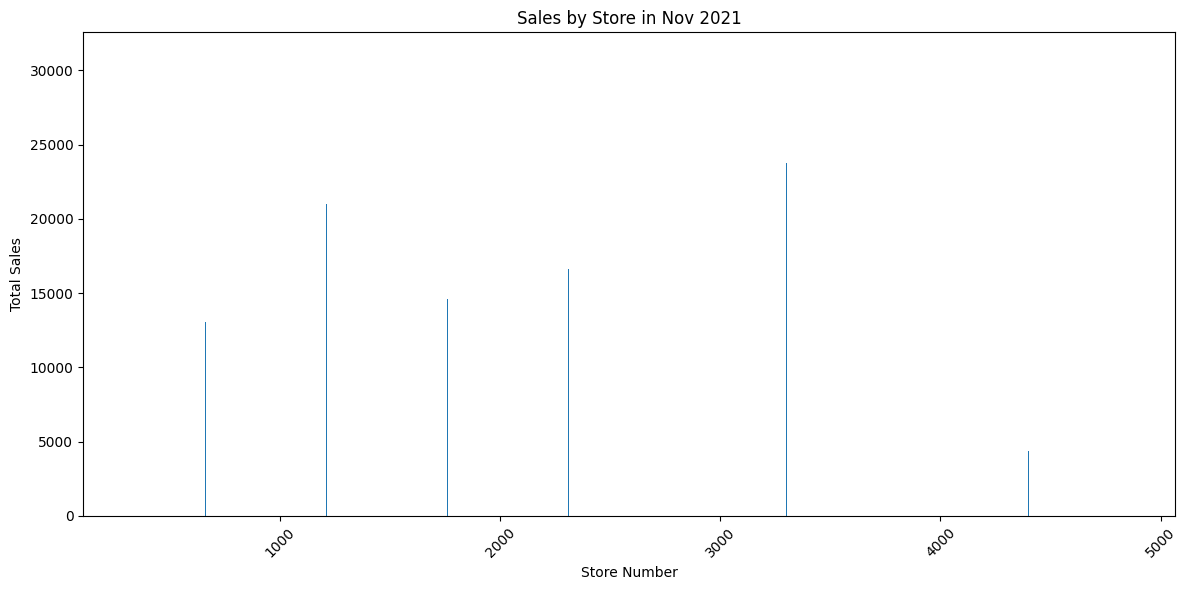

In [75]:
exec(code[0])